<a href="https://colab.research.google.com/github/tinayiluo0322/Adversarial-Patch/blob/main/Adversarial_Patch_broccoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #01

---



---



---


### Creating My Own Adversarial Patch
### Luopeiwen(Tina) Yi


## Notebook Summary: Adversarial Patch Creation and Evaluation ##

This notebook presents the development, training, and evaluation of adversarial patches designed to manipulate the output of a pretrained ResNet-34 model on the ImageNet dataset. The goal of these patches is to force the model to misclassify images into a target class ("broccoli") by applying the patch to images. Throughout the notebook, I explore various methods to create effective adversarial patches, including versions with and without visual disguises, while ensuring robustness against random noise and image transformations.

### Key Components of the Notebook:

1. **Dataset Preparation and Model Setup**:
   The notebook begins by setting up the environment, loading the ResNet-34 model pretrained on ImageNet, and preparing the TinyImageNet dataset for training and validation. The model is evaluated to ensure it can classify images correctly before introducing adversarial patches.

2. **Adversarial Patch Generation**:
   The core functionality of the notebook revolves around the generation of adversarial patches. The patches are trained by minimizing the cross-entropy loss between the model’s predictions and a specified target class ("broccoli"). Each patch is initialized as a learnable parameter and placed at random locations on training images, with Gaussian noise added to increase robustness.

3. **Patch Training and L-Infinity Constraint**:
   The patches are trained using Stochastic Gradient Descent (SGD) with momentum over several epochs. For disguised versions of the patch, an L-infinity norm constraint is introduced, ensuring the pixel values stay within a certain range to prevent the patch from becoming visually conspicuous. Additionally, various versions of the patch, including disguised and non-disguised options, are created and trained separately.

4. **Evaluation and Metrics**:
   After training, the patch is evaluated on a validation set by applying it to random locations on images and measuring its ability to mislead the classifier into predicting "broccoli." The notebook records both top-1 and top-5 accuracy to assess the patch's effectiveness. Key metrics, such as average loss per epoch, final accuracy, and top-5 accuracy, are saved for each version of the patch.

5. **Saving and Visualization**:
   Each trained patch is saved in multiple formats, including a `.pt` model file for further experimentation, a `.png` image for visualization, and a JSON file containing the training metrics. The patch images are visualized at the end of the training process, allowing users to inspect the patch design.

Clone the Github Repository, install dependencies from requirements.txt, and change working directory to location of notebook.

In [ ]:
import os

# Remove Colab default sample_data if it exists
if os.path.isdir("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub repo (force re-clone if it already exists)
repo_name = "XAI_Projects"
git_path = 'https://github.com/tinayiluo0322/XAI_Projects.git'

if os.path.isdir(repo_name):
    !rm -rf "{repo_name}"
!git clone "{git_path}"

# Install dependencies from requirements.txt if it exists
requirements_file = os.path.join(repo_name, 'requirements.txt')
if os.path.isfile(requirements_file):
    !pip install -r "{requirements_file}"
else:
    print("No requirements.txt found, skipping dependency installation.")

# Change working directory to location of notebook
notebook_dir = 'Adversarial_AI'
path_to_notebook = os.path.join(repo_name, notebook_dir)

# Check if the directory exists
if os.path.isdir(path_to_notebook):
    %cd "{path_to_notebook}"
    %ls
else:
    print(f"Directory {path_to_notebook} not found")


Cloning into 'XAI_Projects'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 7), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 191.64 KiB | 19.16 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/XAI_Projects/Adversarial_AI/XAI_Projects/Adversarial_AI/XAI_Projects/Adversarial_AI
adversarial_patch_version1.png  placeholder       training_metrics_version1.json
adversarial_patch_version1.pt   smiling_face.png  XAI_Projects/


Import Libraries

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.transforms.functional as TF

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import urllib.request
from urllib.error import HTTPError
import zipfile

from google.colab import files

from tqdm.notebook import tqdm

from PIL import Image

import random

<ipython-input-27-70ea14f5c59c>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Set seed for reproducibility

In [ ]:
# Function to set the seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # Numpy seed
    torch.manual_seed(seed)  # PyTorch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch seed for current GPU
        torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs

    # Ensure deterministic behavior by disabling certain PyTorch features
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed 42
set_seed(42)

Prepare Pre-trained Torchvision ResNet34 model and load Image Data

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Github URL where the dataset is stored
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Using device: cuda
Unzipping file...


In [ ]:
# Load CNN architecture pretrained on ImageNet
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Sample pre-check evaluation on the performance of the model

In [ ]:
# Evaluation model to check the Top-1 error and Top5 error
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


**Adversarial Patch Version 1: A Non-Disguised Broccoli**

The first version of the adversarial patch is designed to manipulate the predictions of a ResNet-34 image classifier by forcing it to classify any image as "broccoli" when the patch is applied. This version focuses purely on adversarial effectiveness without any attempt to visually disguise the patch. The patch is trained by placing it at random offsets on images, using a ResNet-34 model pretrained on ImageNet. To enhance robustness, random Gaussian noise is added to the images during each training iteration.

The patch is optimized by minimizing the cross-entropy loss between the model’s predictions and the target class "broccoli." Over the course of several epochs, the patch parameters are updated using Stochastic Gradient Descent (SGD) with momentum. The goal is to craft a pattern that, when placed on any image, causes the classifier to output "broccoli" as the top prediction, regardless of the image's actual content.

The training process showed consistent improvement, with the following losses recorded over five epochs:
- **Epoch 0**: Average loss = 1.3785
- **Epoch 1**: Average loss = 0.0561
- **Epoch 2**: Average loss = 0.0340
- **Epoch 3**: Average loss = 0.0308
- **Epoch 4**: Average loss = 0.0246

After training, the patch was evaluated by randomly applying it to images in the validation set. The model's performance was measured using top-1 and top-5 accuracy metrics:
- **Final Top-1 Accuracy**: 0.9386 (93.86% of images were classified as "broccoli")
- **Final Top-5 Accuracy**: 0.9809 (98.09% of images included "broccoli" in the top 5 predictions)

The patch was saved in multiple formats, including a `.pt` file for further experimentation and a `.png` image for visualization. All training metrics, including loss per epoch and accuracy results, were saved in a JSON file for reproducibility. This non-disguised patch effectively increases the classifier’s likelihood of predicting "broccoli" when applied to any image.

In [ ]:
# Place the Patch at Random Offsets on the Image
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [ ]:
# Normalization to map patch values from [-inf, inf] to ImageNet min and max
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:, None, None], torch.FloatTensor(NORM_STD)[:, None, None]
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [ ]:
# Evaluate the patch functionality placing at random locations on different images
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 10 random locations per image, and average the performance
            for _ in range(10):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [ ]:
# Set the save directory to the 'Adversarial_AI' folder inside the cloned repository
save_dir = "/content/XAI_Projects/Adversarial_AI"

# Function to save patch as a .pt file
def save_patch(patch, version):
    filename = f"adversarial_patch_version_{version}.pt"
    save_path = os.path.join(save_dir, filename)
    torch.save(patch, save_path)
    print(f"Patch saved at: {save_path}")
    files.download(save_path)

# Function to save metrics to a JSON file
def save_metrics(metrics, version):
    filename = f"training_metrics_version_{version}.json"
    save_path = os.path.join(save_dir, filename)
    with open(save_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Metrics saved at: {save_path}")
    files.download(save_path)

# Function to visualize and save the adversarial patch as an image
def visualize_patch(patch, version):
    filename = f"adversarial_patch_version_{version}.png"
    patch_np = patch.detach().cpu().numpy()  # Convert to numpy array
    patch_np = np.transpose(patch_np, (1, 2, 0))  # Rearrange to (H, W, C)
    patch_np = np.clip(patch_np, 0, 1)  # Clip values to valid image range [0, 1]

    # Plot and save the patch image
    plt.imshow(patch_np)
    plt.axis('off')  # Hide axes
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    plt.show()
    print(f"Patch image saved at: {save_path}")
    files.download(save_path)

In [ ]:
# Function to add random noise to the image
def add_noise(img, noise_level=0.05):
    noise = torch.randn_like(img) * noise_level  # Gaussian noise
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)  # Ensure values remain within valid range [0, 1]

In [ ]:
# Function to generate a non-disguised patch
def patch_attack(model, target_class, patch_size=64, num_epochs=5, version=1, noise_level=0.05):
    # Leave a small set of images out to check generalization
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    all_losses = []  # Store loss for each epoch
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        epoch_loss = 0
        for img, _ in t:
            # Place the patch on the image
            img = place_patch(img, patch)
            img = img.to(device)

            # Add random noise to the image
            img = add_noise(img, noise_level=noise_level)

            # Forward pass
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            epoch_loss += loss.item()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

        all_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch} completed with average loss: {epoch_loss / len(train_loader)}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    # Save patch, metrics, and visualize
    save_patch(patch.data, version=version)
    metrics = {"loss_per_epoch": all_losses, "accuracy": acc.item(), "top5_accuracy": top5.item()}

    # Print the metrics in a more readable format
    print(f"Final Accuracy (Top-1): {metrics['accuracy']:.4f}")
    print(f"Final Top-5 Accuracy: {metrics['top5_accuracy']:.4f}")

    save_metrics(metrics, version=version)
    visualize_patch(patch.data, version=version)

    return patch.data, metrics

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 0 completed with average loss: 1.3785490803819682


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 completed with average loss: 0.056055371559757206


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 completed with average loss: 0.034015329694375394


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 completed with average loss: 0.030755926773417742


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 completed with average loss: 0.024588090776316157


Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Patch saved at: /content/XAI_Projects/Adversarial_AI/adversarial_patch_version_1.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Accuracy (Top-1): 0.9386
Final Top-5 Accuracy: 0.9809
Metrics saved at: /content/XAI_Projects/Adversarial_AI/training_metrics_version_1.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

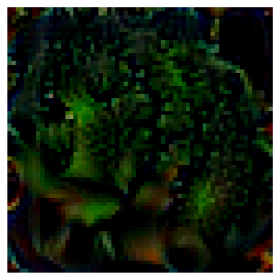

Patch image saved at: /content/XAI_Projects/Adversarial_AI/adversarial_patch_version_1.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Train the adversarial patch targeting "broccoli" class without a disguise.
target_class = get_label_index("broccoli")
patch, metrics = patch_attack(pretrained_model, target_class, patch_size=64, num_epochs=5, version=1, noise_level=0.05)

**Adversarial Patch Version 2: A Disguised Broccoli**

In this version of the adversarial patch, the objective is to create a visually disguised patch that still manipulates the classifier into predicting "broccoli" as the label for any input image. The patch is constrained by an L-infinity norm, which ensures that the pixel values stay within a limited range, making the patch subtle and less noticeable. The model is trained using cross-entropy loss, which maximizes the probability of predicting "broccoli" when the patch is applied to an image.

The patch is optimized through several epochs using Stochastic Gradient Descent (SGD), and random Gaussian noise is added to the images during training to improve robustness against noise. After each backpropagation step, the patch is projected back into the L-infinity constraint to maintain its subtle appearance. The patch is applied to different locations on the image, forcing the classifier to misclassify the input as "broccoli."

The training process over five epochs yielded the following metrics:
- **Epoch 0**: Average loss = 1.6360
- **Epoch 1**: Average loss = 0.1048
- **Epoch 2**: Average loss = 0.0808
- **Epoch 3**: Average loss = 0.0774
- **Epoch 4**: Average loss = 0.0703

After training, the patch was evaluated on a validation set by placing it randomly on the images. The patch demonstrated strong performance, achieving:
- **Final Top-1 Accuracy**: 0.8968 (89.68% of images were classified as "broccoli")
- **Final Top-5 Accuracy**: 0.9546 (95.46% of images included "broccoli" in the top 5 predictions)

The trained patch was saved as a `.pt` file and visualized as a `.png` image. All training metrics, including the loss per epoch, accuracy, and top-5 accuracy, were saved in a JSON file for further analysis. The result is a highly effective, visually disguised adversarial patch that forces the classifier to predict "broccoli" without being overtly detectable.

In [ ]:
# L_infinity norm projection function
def project_patch(patch, epsilon):
    # Ensure that the patch stays within the L_infinity norm constraint
    return torch.clamp(patch, min=-epsilon, max=epsilon)

In [ ]:
# Modified patch_attack function with L_infinity constraint
def patch_attack_disguise(model, target_class, patch_size=64, num_epochs=5, epsilon=0.1, version=1, noise_level=0.05):
    # Leave a small set of images out to check generalization
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    # Initialize patch as a learnable parameter
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)

    # Use Stochastic Gradient Descent (SGD) optimizer
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    all_losses = []  # Store loss for each epoch
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        epoch_loss = 0
        for img, _ in t:
            # Place the patch on the image
            img = place_patch(img, patch)
            img = img.to(device)

            # Add random noise to the image
            img = add_noise(img, noise_level=noise_level)

            # Forward pass
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            # Project the patch back into the L_infinity ball
            with torch.no_grad():
                patch.data = project_patch(patch.data, epsilon)

            epoch_loss += loss.item()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

        all_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch} completed with average loss: {epoch_loss / len(train_loader)}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    # Save patch, metrics, and visualize
    save_patch(patch.data, version=version)
    metrics = {"loss_per_epoch": all_losses, "accuracy": acc.item(), "top5_accuracy": top5.item()}

    # Print the metrics in a more readable format
    print(f"Final Accuracy (Top-1): {metrics['accuracy']:.4f}")
    print(f"Final Top-5 Accuracy: {metrics['top5_accuracy']:.4f}")

    save_metrics(metrics, version=version)
    visualize_patch(patch.data, version=version)

    return patch.data, metrics


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 0 completed with average loss: 1.6360045886598527


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 completed with average loss: 0.10483320013819529


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 completed with average loss: 0.08079633563091712


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 completed with average loss: 0.07742186767947194


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 completed with average loss: 0.07030060738824041


Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Patch saved at: /content/XAI_Projects/Adversarial_AI/adversarial_patch_version_2.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Accuracy (Top-1): 0.8968
Final Top-5 Accuracy: 0.9546
Metrics saved at: /content/XAI_Projects/Adversarial_AI/training_metrics_version_2.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

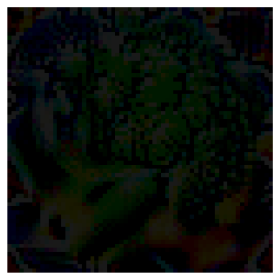

Patch image saved at: /content/XAI_Projects/Adversarial_AI/adversarial_patch_version_2.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Train the adversarial patch targeting "broccoli" class with a disguise.
target_class = get_label_index("broccoli")
patch, metrics = patch_attack_disguise(pretrained_model, target_class, patch_size=64, num_epochs=5, epsilon=0.1, version=2, noise_level=0.05)